In [64]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as Data
import matplotlib.pyplot as plt

In [65]:
# 生成数据集
max_degree = 100
n_train, n_test = 1000, 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=[n_train + n_test, 1])
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1) # math.gamma(n) = (n - 1)!, 除以该系数缓解过拟合

labels = np.dot(poly_features, true_w)
labels += np.random.normal(size=labels.shape, scale=0.1)

In [66]:
# 生成训练数据
poly_features = torch.from_numpy(poly_features).float()
labels = torch.from_numpy(labels).float()

train_data = Data.TensorDataset(poly_features[:n_train, :], labels[:n_train])
test_data = Data.TensorDataset(poly_features[n_train:n_train + n_test, :], labels[n_train:n_train + n_test])

batch_size = 10
train_iter = Data.DataLoader(train_data, batch_size=10, shuffle=True)
test_iter = Data.DataLoader(test_data, batch_size=10, shuffle=True)

In [67]:
# 定义模型
class PolyNet(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(PolyNet, self).__init__()
        self.linear = nn.Linear(n_inputs, n_outputs, bias=False)
        self._init_params()
    
    def _init_params(self):
        nn.init.normal_(self.linear.weight, mean=0, std=0.01)
    
    def forward(self,x):
        x = self.linear(x)
        return x

In [68]:
# 定义函数评估损失
def evaluate_loss(net, loss, data_iter, n_inputs):
    loss_sum = 0.0
    
    for x, y in data_iter:
        y_hat = net(x[:, 0:n_inputs])
        l = loss(y_hat, y.view(y_hat.shape))
        loss_sum += l.item()
    
    return loss_sum / len(data_iter)

In [69]:
# 定义训练函数
def train(n_inputs, n_outputs, lr, n_epochs):
    net = PolyNet(n_inputs, n_outputs)
    loss = nn.MSELoss()
    optimizer = torch.optim.SGD(net.parameters(), lr = lr)

    train_losses, test_losses = [], []

    for epoch in range(n_epochs):    
        for x, y in train_iter:
            y_hat = net(x[:, 0:n_inputs])
            l = loss(y_hat, y.view(y_hat.shape))

            optimizer.zero_grad()
            l.backward()
            optimizer.step()

        train_loss = evaluate_loss(net, loss, train_iter, n_inputs)
        test_loss = evaluate_loss(net, loss, test_iter, n_inputs)
        train_losses.append(train_loss)
        test_losses.append(test_loss)

        if (epoch + 1) % 50 == 0:
            print(f'epoch {epoch + 1: d}, train loss {train_loss: .4f}, test loss {test_loss: .4f}')
            
    fig, ax = plt.subplots(figsize=[5, 2.5])

    ax.set_ylim(1e-3, 1e3)
    ax.set_yscale('log')
    ax.set_xlim(0, 400)

    ax.plot(range(1, n_epochs + 1), train_losses, label='train loss', color='blue', linestyle='--')
    ax.plot(range(1, n_epochs + 1), test_losses, label='test loss', color='purple', linestyle='-.')
    ax.grid(True)

    plt.legend()
    plt.show()   
    
    print(net.linear.weight.data.numpy())

epoch  50, train loss  0.0138, test loss  0.0361
epoch  100, train loss  0.0100, test loss  0.0099
epoch  150, train loss  0.0100, test loss  0.0095
epoch  200, train loss  0.0100, test loss  0.0094
epoch  250, train loss  0.0100, test loss  0.0094
epoch  300, train loss  0.0100, test loss  0.0094
epoch  350, train loss  0.0100, test loss  0.0094
epoch  400, train loss  0.0100, test loss  0.0094


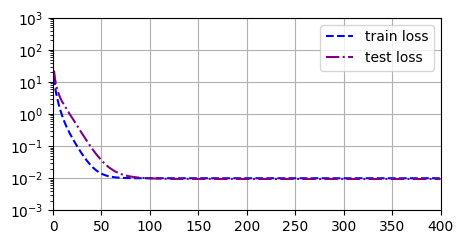

[[ 5.0001884  1.2093014 -3.4033139  5.5887504]]


In [70]:
# 三阶多项式函数拟合（正常）
train(4, 1, 0.003, 400)

epoch  50, train loss  9.3006, test loss  18.3973
epoch  100, train loss  9.3013, test loss  18.4582
epoch  150, train loss  9.3009, test loss  18.3750
epoch  200, train loss  9.3037, test loss  18.2810
epoch  250, train loss  9.3007, test loss  18.4303
epoch  300, train loss  9.3006, test loss  18.3998
epoch  350, train loss  9.3007, test loss  18.4234
epoch  400, train loss  9.3006, test loss  18.3990


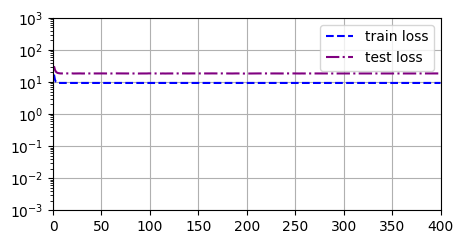

[[3.3130412 3.8602026]]


In [71]:
# 一阶多项式函数拟合（欠拟合）
train(2, 1, 0.003, 400)

epoch  50, train loss  0.0405, test loss  0.0838
epoch  100, train loss  0.0240, test loss  0.0722
epoch  150, train loss  0.0192, test loss  0.0834
epoch  200, train loss  0.0172, test loss  0.0878
epoch  250, train loss  0.0160, test loss  0.0830
epoch  300, train loss  0.0151, test loss  0.0756
epoch  350, train loss  0.0144, test loss  0.0667
epoch  400, train loss  0.0137, test loss  0.0583


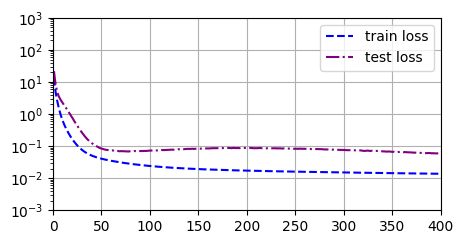

[[ 4.9926410e+00  1.3154298e+00 -3.3651083e+00  5.1016669e+00
  -1.5045036e-01  1.0911453e+00  2.2344914e-01  8.6552851e-02
   5.0891794e-02 -3.9310660e-03]]


In [72]:
# 高阶多项式函数拟合（过拟合）
train(10 , 1, 0.003, 400)